# Working with Metro Interstate Traffic Volume Data Set


https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume

**Data Set Information:**

Hourly Interstate 94 Westbound traffic volume for MN DoT ATR station 301, roughly midway between Minneapolis and St Paul, MN. Hourly weather features and holidays included for impacts on traffic volume.


**Attribute Information:**





| Feature              | Description                                                                     |
| -------------------- | ------------------------------------------------------------------------------- |
| holiday              | Categorical US National holidays plus regional holiday, Minnesota State Fair
| temp                 | Numeric Average temp in kelvin
| rain_1h              | Numeric Amount in mm of rain that occurred in the hour
| snow_1h              | Numeric Amount in mm of snow that occurred in the hour
| clouds_all           | Numeric Percentage of cloud cover
| weather_main         | Categorical Short textual description of the current weather
| weather_description  | Categorical Longer textual description of the current weather
| date_time            | DateTime Hour of the data collected in local CST time
| traffic_volume       | Numeric Hourly I-94 ATR 301 reported westbound traffic volume



**Task:**

Make forecast 1 week ahead (excluding the date itself) for:
- 25 December 2017
- 5 July 2017
- 24 September 2018

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from scipy.optimize import minimize
from scipy.stats import boxcox
from scipy.special import inv_boxcox

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, \
    median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly

from itertools import product
from tqdm import tqdm_notebook

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings("ignore")

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [2]:
df = pd.read_csv("Metro_Interstate_Traffic_Volume.csv", sep=",", decimal='.')
df

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
...,...,...,...,...,...,...,...,...,...
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450


## EDA

Оставим для первого приближения только 4 столбца.

In [3]:
df = df[['holiday','temp','date_time','traffic_volume']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         48204 non-null  object 
 1   temp            48204 non-null  float64
 2   date_time       48204 non-null  object 
 3   traffic_volume  48204 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 1.5+ MB


Пропусков в данных нет, проверим на дубликаты по времени.

In [4]:
df[df.duplicated('date_time', keep=False)]

,holiday,temp,date_time,traffic_volume
178,None,281.25,2012-10-10 07:00:00,6793
179,None,281.25,2012-10-10 07:00:00,6793
180,None,280.10,2012-10-10 08:00:00,6283
181,None,280.10,2012-10-10 08:00:00,6283
182,None,279.61,2012-10-10 09:00:00,5680
...,...,...,...,...
48173,None,280.68,2018-09-29 19:00:00,3818
48192,None,283.48,2018-09-30 14:00:00,4380
48193,None,283.48,2018-09-30 14:00:00,4380
48194,None,283.84,2018-09-30 15:00:00,4302


Удалим все дублирующиеся строки.

In [5]:
df = df[df.duplicated('date_time')==False].reset_index(drop=True)
df

,holiday,temp,date_time,traffic_volume
0,None,288.28,2012-10-02 09:00:00,5545
1,None,289.36,2012-10-02 10:00:00,4516
2,None,289.58,2012-10-02 11:00:00,4767
3,None,290.13,2012-10-02 12:00:00,5026
4,None,291.14,2012-10-02 13:00:00,4918
...,...,...,...,...
40570,None,283.45,2018-09-30 19:00:00,3543
40571,None,282.76,2018-09-30 20:00:00,2781
40572,None,282.73,2018-09-30 21:00:00,2159
40573,None,282.09,2018-09-30 22:00:00,1450


Посмотрим распределение столбца holiday.

In [6]:
df['holiday'].value_counts()

None                         40522
Memorial Day                     5
Columbus Day                     5
New Years Day                    5
Veterans Day                     5
State Fair                       5
Thanksgiving Day                 5
Washingtons Birthday             5
Labor Day                        5
Christmas Day                    5
Independence Day                 5
Martin Luther King Jr Day        3
Name: holiday, dtype: int64

In [7]:
df[df['holiday']!='None']

,holiday,temp,date_time,traffic_volume
126,Columbus Day,273.080,2012-10-08 00:00:00,455
926,Veterans Day,288.120,2012-11-12 00:00:00,1000
1164,Thanksgiving Day,278.540,2012-11-22 00:00:00,919
1938,Christmas Day,264.400,2012-12-25 00:00:00,803
2103,New Years Day,263.490,2013-01-01 00:00:00,1439
3066,Washingtons Birthday,258.960,2013-02-18 00:00:00,556
5236,Memorial Day,286.370,2013-05-27 00:00:00,863
6075,Independence Day,290.080,2013-07-04 00:00:00,1060
7178,State Fair,297.420,2013-08-22 00:00:00,661
7340,Labor Day,288.780,2013-09-02 00:00:00,1041


В датасете существенный изъян: праздники проставлены только в строках, соответствующих началу суток. 

Перекодируем столбец holiday в 0/1.

In [8]:
df['holiday'] = (df['holiday']!='None').astype(int)

Построим боксплоты для числовых столбцов.

<AxesSubplot:xlabel='temp'>

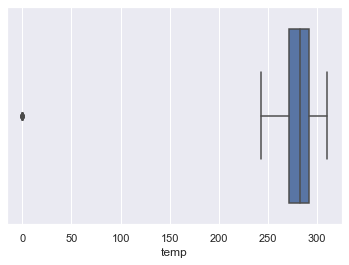

In [9]:
sns.boxplot(df['temp'])

<AxesSubplot:xlabel='traffic_volume'>

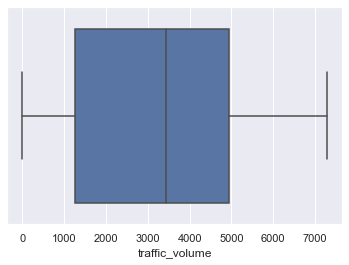

In [10]:
sns.boxplot(df['traffic_volume'])

In [11]:
df[df['temp']==0]

,holiday,temp,date_time,traffic_volume
10079,0,0.0,2014-01-31 03:00:00,361
10080,0,0.0,2014-01-31 04:00:00,734
10081,0,0.0,2014-01-31 05:00:00,2557
10082,0,0.0,2014-01-31 06:00:00,5150
10127,0,0.0,2014-02-02 03:00:00,291
10128,0,0.0,2014-02-02 04:00:00,284
10129,0,0.0,2014-02-02 05:00:00,434
10130,0,0.0,2014-02-02 06:00:00,739
10131,0,0.0,2014-02-02 07:00:00,962
10132,0,0.0,2014-02-02 08:00:00,1670


Очевидно, что строки с температурой 0 это ошибки заполнения данных. Переведём такие значения в NaN, чтобы потом применить интерполяцию.

In [12]:
df['temp'] = df['temp'].apply(lambda x: np.nan if x==0 else x)
df[df['temp']==0]

,holiday,temp,date_time,traffic_volume


Проверим, нет ли пропусков по столбцу даты (все ли строки отстоят друг от друга ровно на час).

In [13]:
df['date_time'] = pd.to_datetime(df['date_time'])
data_range = pd.date_range(start=df['date_time'].min(), end=df['date_time'].max(), freq='1H')
df_data_range = pd.DataFrame(data_range, columns=['date_time'])
df_data_range

,date_time
0,2012-10-02 09:00:00
1,2012-10-02 10:00:00
2,2012-10-02 11:00:00
3,2012-10-02 12:00:00
4,2012-10-02 13:00:00
...,...
52546,2018-09-30 19:00:00
52547,2018-09-30 20:00:00
52548,2018-09-30 21:00:00
52549,2018-09-30 22:00:00


В созданном диапазоне дат на 12000 строк больше, чем в нашем датасете. Значит, нужно расширить датасет, а нулевые значения в данных заполнить интерполяцией.

In [16]:
df = pd.merge(df, df_data_range, on='date_time', how='outer').sort_values(by='date_time').reset_index(drop=True)
df.interpolate(inplace=True)
df[df.isna().any(axis=1)]

,holiday,temp,date_time,traffic_volume


In [18]:
df['holiday'].value_counts()

0.0    52493
1.0       53
0.5        5
Name: holiday, dtype: int64

После интерполяции некоторые значения праздников оказались 0,5. Пройдёмся по всему датасету и выставим значения столбца holiday в то значение, которое имеет строка начала текущих суток.

In [19]:
import datetime

def is_holiday(date_time):
    sub = df[df['date_time'] == date_time.strftime('%Y-%m-%d 00:00:00')]
    if (sub.shape[0] > 0):
        return sub['holiday'].iloc[0]
    return 0

df['holiday'] = df.apply(lambda row: is_holiday(row['date_time']), axis=1)
df['holiday'].value_counts()

0.0    51279
1.0     1272
Name: holiday, dtype: int64

Сгенерируем новые столбцы для дня недели и часа, взяв информацию из временных меток.

In [20]:
df['weekday'] = df['date_time'].dt.weekday
df['hour'] = df['date_time'].dt.hour
df

,holiday,temp,date_time,traffic_volume,weekday,hour
0,0.0,288.28,2012-10-02 09:00:00,5545.0,1,9
1,0.0,289.36,2012-10-02 10:00:00,4516.0,1,10
2,0.0,289.58,2012-10-02 11:00:00,4767.0,1,11
3,0.0,290.13,2012-10-02 12:00:00,5026.0,1,12
4,0.0,291.14,2012-10-02 13:00:00,4918.0,1,13
...,...,...,...,...,...,...
52546,0.0,283.45,2018-09-30 19:00:00,3543.0,6,19
52547,0.0,282.76,2018-09-30 20:00:00,2781.0,6,20
52548,0.0,282.73,2018-09-30 21:00:00,2159.0,6,21
52549,0.0,282.09,2018-09-30 22:00:00,1450.0,6,22


## Baseline

In [21]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [22]:
def plotModelResults(model, X_train, y_train, X_test, y_test,
                     plot_train=False, plot_intervals=False, plot_anomalies=False):
    """
    Plots modelled vs fact values, prediction intervals and anomalies
    """
    tscv = TimeSeriesSplit(n_splits=5)
    prediction = model.predict(X_test)
    
    N_train = len(y_train)
    N_test = len(y_test)
    train_index = range(N_train)
    test_index = range(N_train, N_train+N_test)
    
    plt.figure(figsize=(15, 7))
    if plot_train:
        plt.plot(train_index, y_train.values, label="train actual")
    plt.plot(test_index, y_test.values, label="actual", linewidth=2.0)
    plt.plot(test_index, prediction, "g", label="prediction", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, cv=tscv, scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(test_index, lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(test_index, upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(test_index, anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)

Напишем маленький класс Baseline, который будет предсказывать значение трафика по средним значениям для текущих часа и дня недели.

In [23]:
class Baseline():
    def predict(self, data):
        data = data.apply(lambda row: mean_traffic[row['weekday']][row['hour']], axis=1)
        return data

Напишем функцию, которая будет выбирать нужный объём датасета, разбивать на train/test и строить предсказание для test.

In [24]:
def make_prediction_by_mean_traffic(data, months_for_train, weeks_for_test=2):
    global mean_traffic
    
    train_from = data['date_time'].max() - pd.DateOffset(months=months_for_train)
    test_from = data['date_time'].max() - pd.DateOffset(weeks=weeks_for_test)
    
    data_train = data[(data['date_time'] >= train_from) & (data['date_time'] < test_from)]
    data_test = data[data['date_time'] >= test_from]
    
    y_train = data_train['traffic_volume']
    y_test = data_test['traffic_volume']
    X_train = data_train.drop('traffic_volume', axis=1)
    X_test = data_test.drop('traffic_volume', axis=1)
    
    mean_traffic = data_train.groupby(['weekday', 'hour'])['traffic_volume'].mean()
    
    baseline = Baseline()
    plotModelResults(baseline, X_train=data_train, y_train=y_train, X_test=data_test, y_test=y_test)

Очевидно, что для успешного предскзания вряд ли нужны данные трафика за 6 лет. Построим несколько предсказаний, меняя объём датасета, отсчитывая месяцы от его конца.

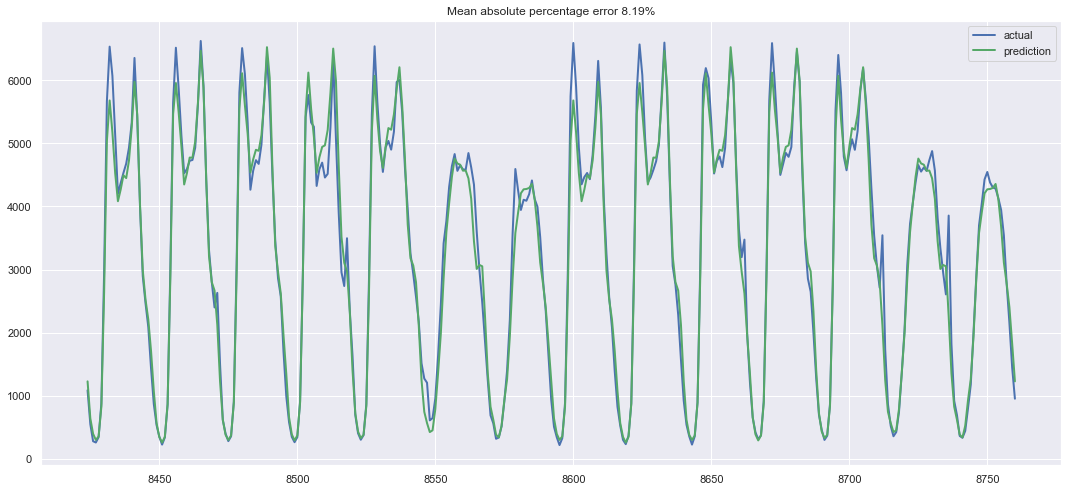

In [25]:
make_prediction_by_mean_traffic(df, 12)

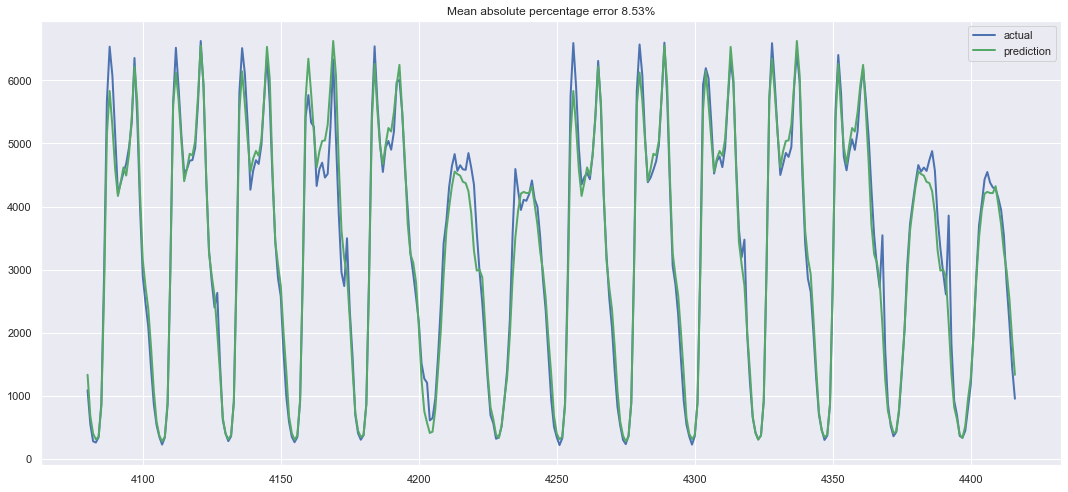

In [26]:
make_prediction_by_mean_traffic(df, 6)

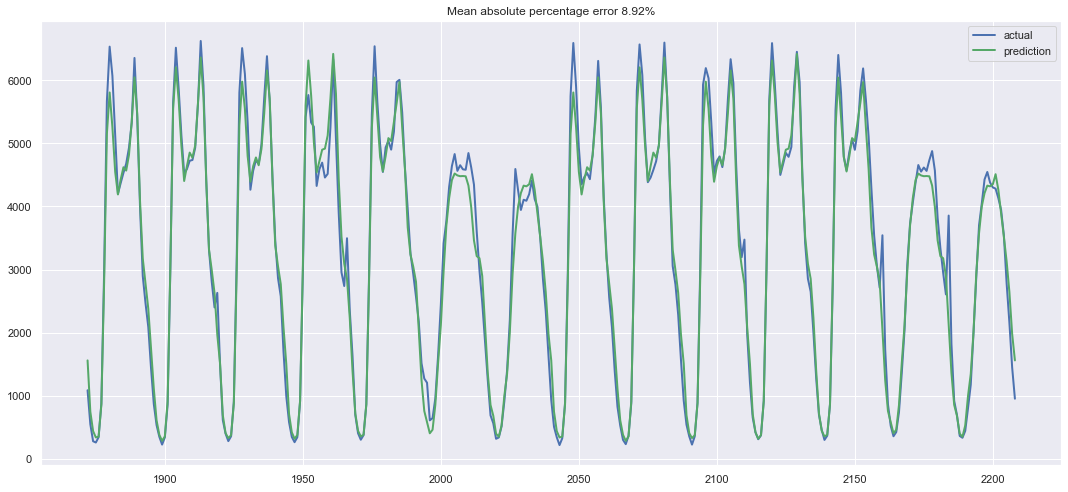

In [27]:
make_prediction_by_mean_traffic(df, 3)

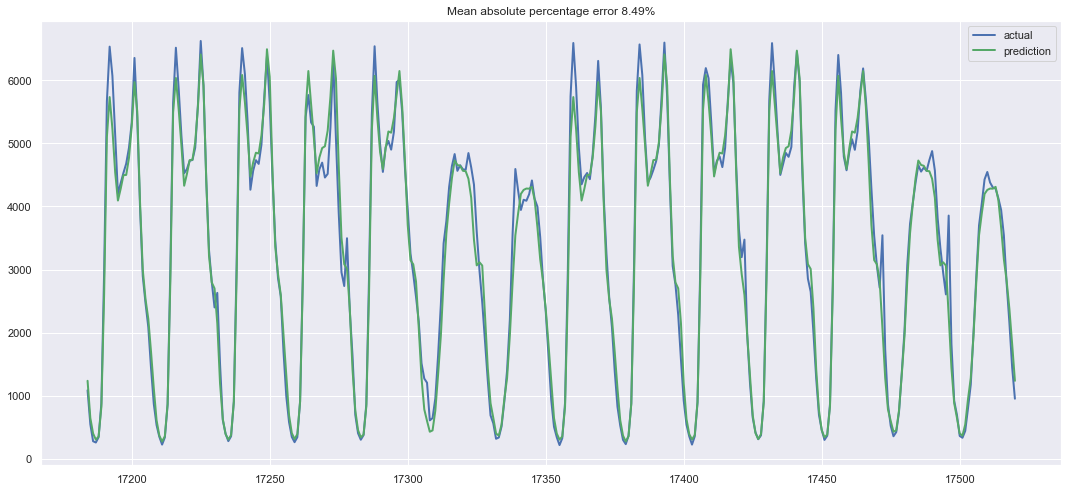

In [28]:
make_prediction_by_mean_traffic(df, 24)

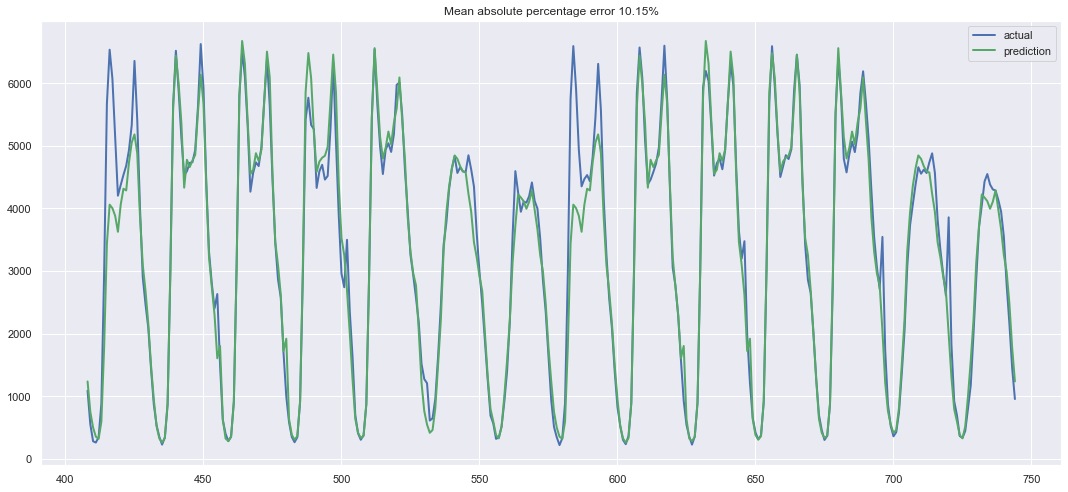

In [29]:
make_prediction_by_mean_traffic(df, 1)

По итогам небольшого перебора остановимся на том, что уместно оставить датасет за 12 последних месяцев. В таком случае ошибка MAPE по Baseline составляет 8,19%.

## SARIMA

In [30]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

import statsmodels.api as sm

def plotSARIMA(series, model, n_steps, s=24, d=1, plot_intervals=True, alpha=0.2):
    """
    Plots model vs predicted values
    :param series:   Dataset with timeseries
    :type series:     pd.DataFrame
    :param model:    Fitted SARIMA model
    :type model:      sm.tsa.statespace.SARIMAX
    :param n_steps:  Number of steps to predict in the future
    :type n_steps:    int
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.get_forecast(steps=n_steps)
    model_predictions = data.arima_model.append(forecast.predicted_mean)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    
    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))    
    
    plt.plot(model_predictions, color='r', label="model")
    plt.plot(data.actual, label="actual")
    
    if plot_intervals:
        intervals = forecast.conf_int(alpha=alpha)
        intervals.columns=['lower', 'upper']
        plt.plot(intervals['lower'], "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(intervals['upper'], "r--", alpha=0.5)
        plt.fill_between(x=intervals.index, y1=intervals['upper'],
                         y2=intervals['lower'], alpha=0.2, color = "grey")
    
    plt.legend()
    plt.grid(True)

Для прогнозирования по методике SARIMA скопируем исходный датасет за последний год и оставим на test последние две недели. Нам потребуются только временные метки и целевая переменная.

In [31]:
df_sarima = df.copy()
df_sarima_test = df_sarima[df_sarima['date_time'] >= pd.to_datetime('2018-09-17')]
df_sarima_test = df_sarima_test[['date_time','traffic_volume']].set_index('date_time', drop=True)
df_sarima = df_sarima[(df_sarima['date_time'] >= pd.to_datetime('2017-09-17')) & (df_sarima['date_time'] < pd.to_datetime('2018-09-17'))]
df_sarima = df_sarima[['date_time','traffic_volume']].set_index('date_time', drop=True)
df_sarima_test

,traffic_volume
date_time,
2018-09-17 00:00:00,550.0
2018-09-17 01:00:00,280.0
2018-09-17 02:00:00,260.0
2018-09-17 03:00:00,344.0
2018-09-17 04:00:00,880.0
...,...
2018-09-30 19:00:00,3543.0
2018-09-30 20:00:00,2781.0
2018-09-30 21:00:00,2159.0


Построим модель для небольших коэффициентов. Показатель сезонности s установим в количество часов в неделе.

C:\Users\andsi\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\andsi\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


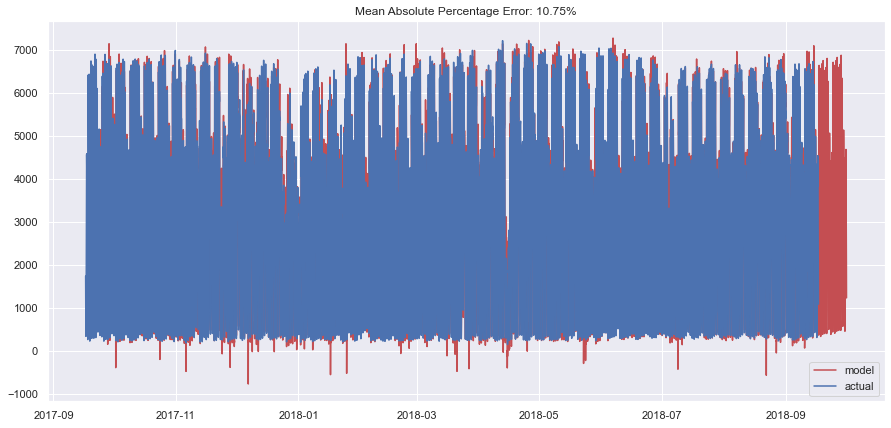

In [26]:
p, d, q = 1, 1, 1
P, D, Q = 0, 1, 0
s = 24*7

model = sm.tsa.statespace.SARIMAX(df_sarima['traffic_volume'],
                                  order=(p, d, q),
                                  seasonal_order=(P, D, Q, s)).fit(disp=-1, low_memory=True)

plotSARIMA(df_sarima, model, n_steps=24*7*2, s=s, d=d, plot_intervals=False)

Ошибка MAPE для всей модели больше, чем у Baseline. Посчитаем точную ошибку для тестовой выборки.

In [27]:
forecast = model.get_forecast(steps=24*7*2)
mean_absolute_percentage_error(forecast.predicted_mean,df_sarima_test['traffic_volume'])

11.376965718189902

Ошибка большая, требуется оптимизация параметров. Так как для годового датасета перебор идёт слишком долго, я сделал перебор в отдельном файле для укороченного датасета и скопировал параметры, при которых AIC минимален.

C:\Users\andsi\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\andsi\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\andsi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


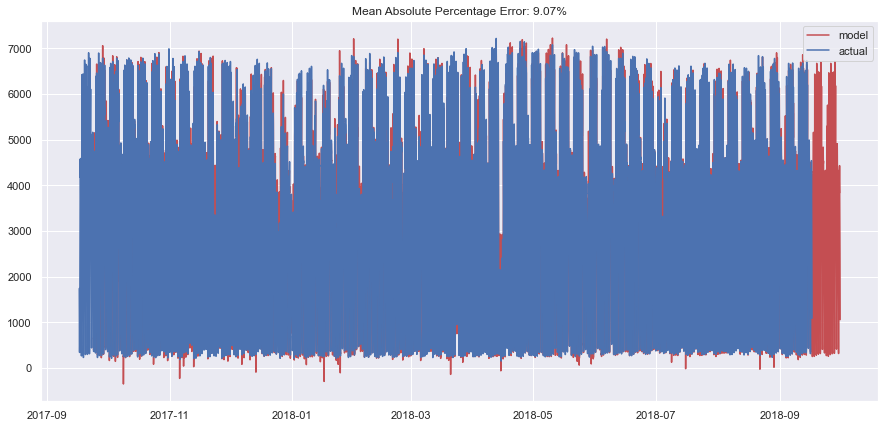

In [25]:
p, d, q = 2, 1, 3
P, D, Q = 1, 1, 0
s = 24*7

model = sm.tsa.statespace.SARIMAX(df_sarima['traffic_volume'],
                                  order=(p, d, q),
                                  seasonal_order=(P, D, Q, s)).fit(disp=-1, low_memory=True)

plotSARIMA(df_sarima, model, n_steps=24*7*2, s=s, d=d, plot_intervals=False)

При данных параметрах ошибка для модели в целом меньше. Построим график для последних 4 недель, а для тестовой выборки построим также доверительные интервалы.

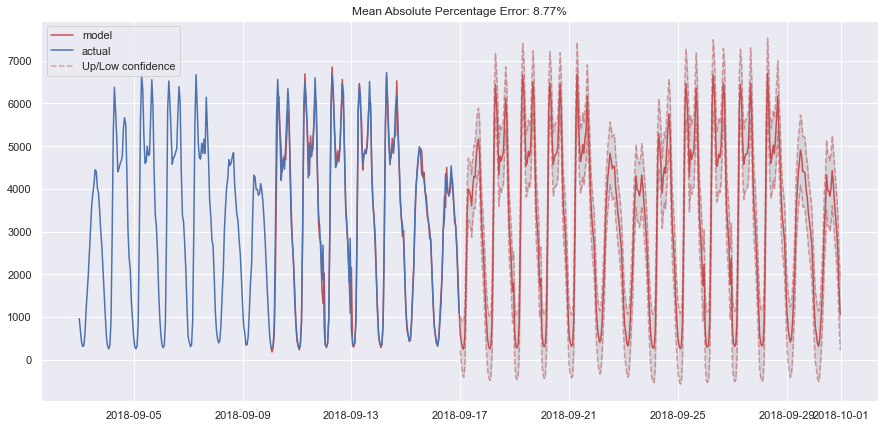

In [29]:
plotSARIMA(df_sarima[-24*7*2:], model, n_steps=24*7*2, s=s, d=d, plot_intervals=True)

In [26]:
forecast = model.get_forecast(steps=24*7*2)
mean_absolute_percentage_error(forecast.predicted_mean,df_sarima_test['traffic_volume'])

9.514041304168405

Ошибка MAPE даже у оптимизированной модели SARIMA больше, чем у Baseline. Возможно, перебор параметров на более мощных компьютерах дал бы лучший результат, но мы попробуем использовать другие техники.

## Regression and Gradient Boosting

Для прогнозирования с использованием привычных моделей машинного обучения скопируем исходный датасет за последний год и оставим на test последние две недели. Нам потребуются все столбцы, кроме температуры, поскольку для предсказания будущих значений мы не знаем температуру наперёд.

In [32]:
df_regr = df.copy()
df_regr_test = df_regr[df_regr['date_time'] >= pd.to_datetime('2018-09-17')]
df_regr_test = df_regr_test[['date_time','traffic_volume','holiday','weekday','hour']].set_index('date_time', drop=True)
df_regr = df_regr[(df_regr['date_time'] >= pd.to_datetime('2017-09-17')) & (df_regr['date_time'] < pd.to_datetime('2018-09-17'))]
df_regr = df_regr[['date_time','traffic_volume','holiday','weekday','hour']].set_index('date_time', drop=True)
df_regr_test

,traffic_volume,holiday,weekday,hour
date_time,,,,
2018-09-17 00:00:00,550.0,0.0,0,0
2018-09-17 01:00:00,280.0,0.0,0,1
2018-09-17 02:00:00,260.0,0.0,0,2
2018-09-17 03:00:00,344.0,0.0,0,3
2018-09-17 04:00:00,880.0,0.0,0,4
...,...,...,...,...
2018-09-30 19:00:00,3543.0,0.0,6,19
2018-09-30 20:00:00,2781.0,0.0,6,20
2018-09-30 21:00:00,2159.0,0.0,6,21


In [33]:
X_train = df_regr.drop('traffic_volume', axis=1)
y_train = df_regr['traffic_volume']
X_test = df_regr_test.drop('traffic_volume', axis=1)
y_test = df_regr_test['traffic_volume']
y_test

date_time
2018-09-17 00:00:00     550.0
2018-09-17 01:00:00     280.0
2018-09-17 02:00:00     260.0
2018-09-17 03:00:00     344.0
2018-09-17 04:00:00     880.0
                        ...  
2018-09-30 19:00:00    3543.0
2018-09-30 20:00:00    2781.0
2018-09-30 21:00:00    2159.0
2018-09-30 22:00:00    1450.0
2018-09-30 23:00:00     954.0
Name: traffic_volume, Length: 336, dtype: float64

Выполним масштабирование данных.

In [34]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Построим обычную линейную регрессию.

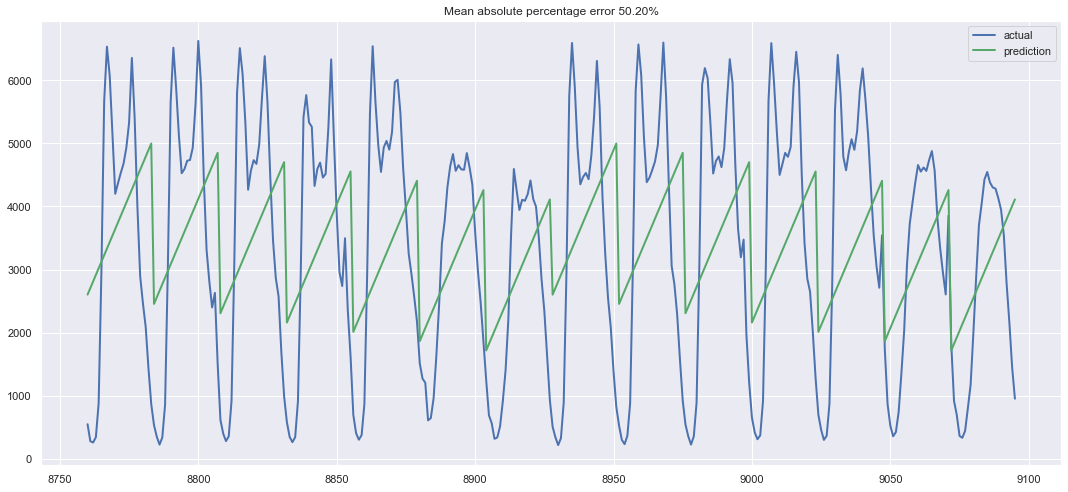

In [35]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
plotModelResults(lin_reg, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

Видно, что линейная модель не способна вписать в себя наши данные, ошибка зашкаливает. Попробуем более продвинутые модели регрессии.

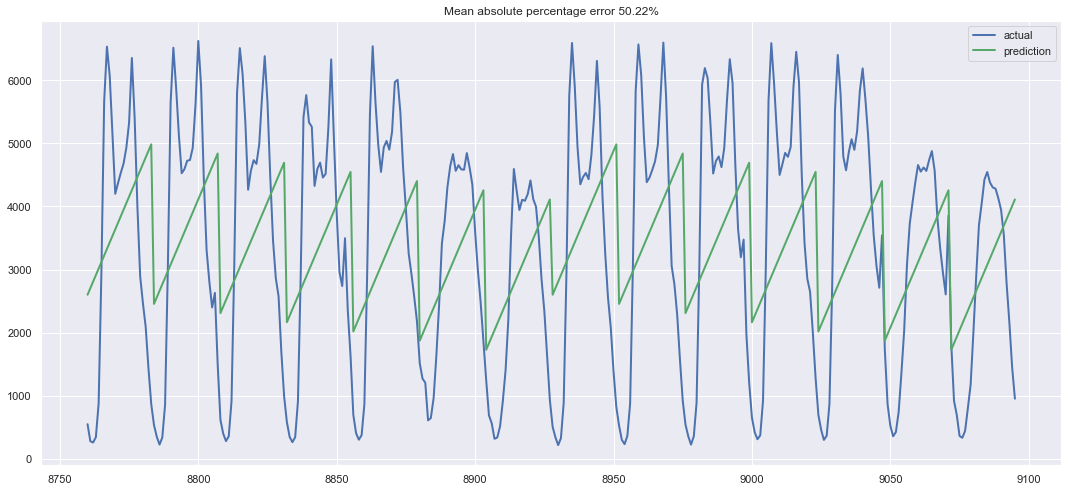

In [36]:
lasso = Lasso()
lasso.fit(X_train, y_train)
plotModelResults(lasso, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

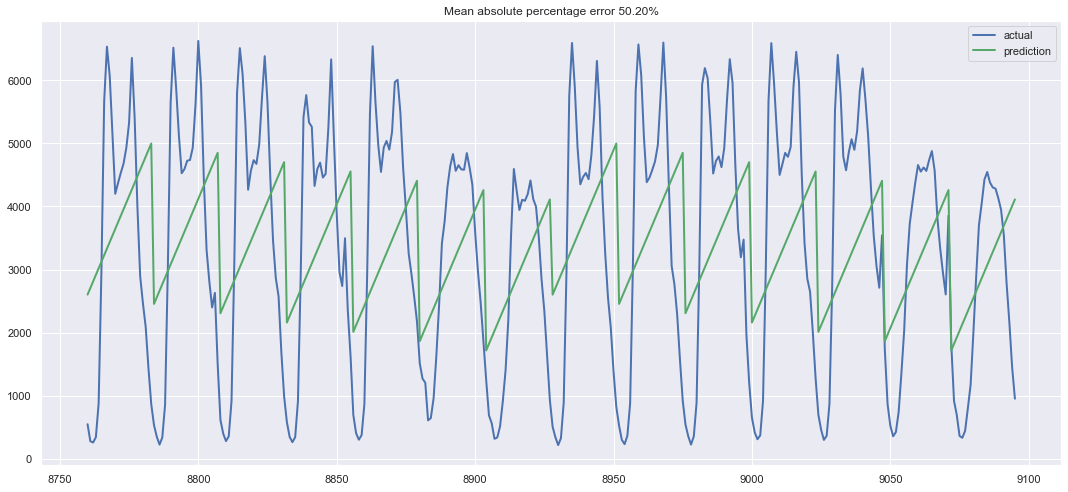

In [37]:
ridge = LinearRegression()
ridge.fit(X_train, y_train)
plotModelResults(ridge, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

Всё то же самое, значит, требуется принципиально другой подход. Попробуем градиентный бустинг.

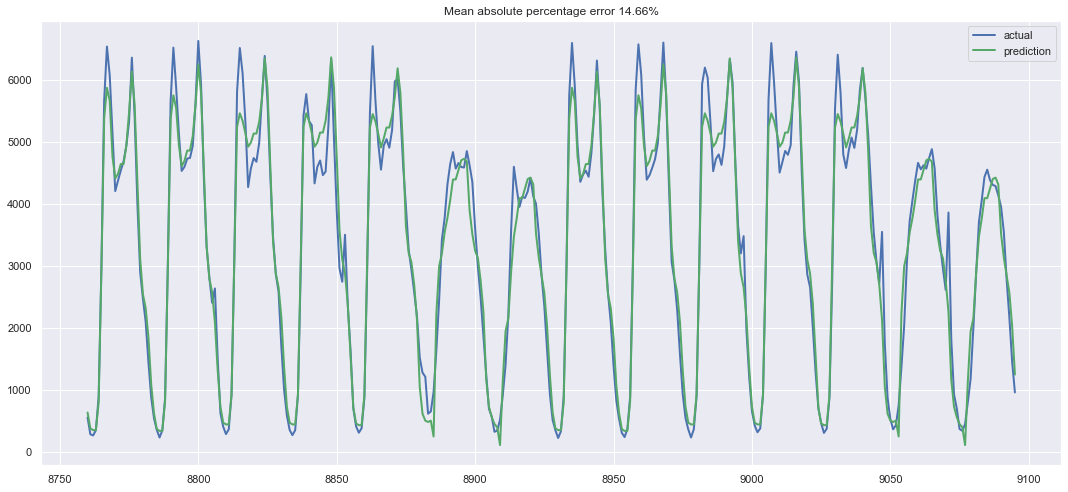

In [38]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)
plotModelResults(gbr, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

Очевидно, бустинг гораздо лучше подходит для данной задачи. Можно понастраивать его параметры, но лучше сразу попробовать продвинутую модель CatBoost.

Wall time: 11.4 s


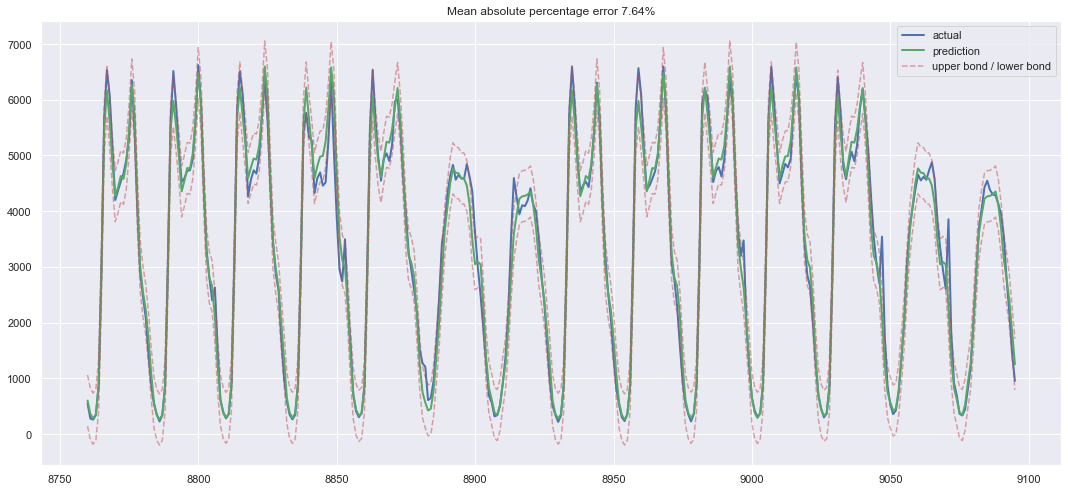

In [39]:
%%time
from catboost import CatBoostRegressor
cat_regr = CatBoostRegressor(logging_level = 'Silent')
cat_regr.fit(X_train, y_train)
plotModelResults(cat_regr, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, plot_intervals=True)

Наконец-то появилась модель, которая работает лучше Baseline. Попробуем улучшить результаты CatBoost, поработая с исходным датасетом.

В первую очередь, почему бы всё-таки не использовать температуру? Для обучения модели можно задействовать измеренные значения, а для тестовой выборки предсказать температуру. Например, по среднему значению за предыдущие годы или применив SARIMA.

Но для начала построим модель, просто оставив столбец температуры как есть.

In [40]:
df_regr = df.copy()
df_regr_test = df_regr[df_regr['date_time'] >= pd.to_datetime('2018-09-17')]
df_regr_test = df_regr_test[['date_time','traffic_volume','holiday','weekday','hour','temp']].set_index('date_time', drop=True)
df_regr = df_regr[(df_regr['date_time'] >= pd.to_datetime('2017-09-17')) & (df_regr['date_time'] < pd.to_datetime('2018-09-17'))]
df_regr = df_regr[['date_time','traffic_volume','holiday','weekday','hour','temp']].set_index('date_time', drop=True)
df_regr_test

,traffic_volume,holiday,weekday,hour,temp
date_time,,,,,
2018-09-17 00:00:00,550.0,0.0,0,0,296.58
2018-09-17 01:00:00,280.0,0.0,0,1,296.19
2018-09-17 02:00:00,260.0,0.0,0,2,295.82
2018-09-17 03:00:00,344.0,0.0,0,3,295.83
2018-09-17 04:00:00,880.0,0.0,0,4,295.68
...,...,...,...,...,...
2018-09-30 19:00:00,3543.0,0.0,6,19,283.45
2018-09-30 20:00:00,2781.0,0.0,6,20,282.76
2018-09-30 21:00:00,2159.0,0.0,6,21,282.73


In [41]:
X_train = df_regr.drop('traffic_volume', axis=1)
y_train = df_regr['traffic_volume']
X_test = df_regr_test.drop('traffic_volume', axis=1)
y_test = df_regr_test['traffic_volume']

In [42]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Wall time: 15.7 s


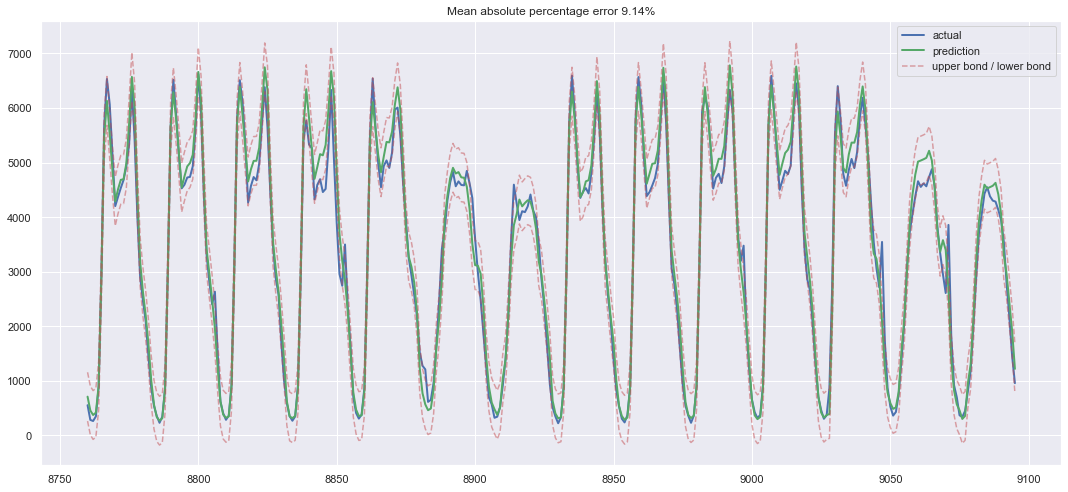

In [43]:
%%time
from catboost import CatBoostRegressor
cat_regr = CatBoostRegressor(logging_level = 'Silent')
cat_regr.fit(X_train, y_train)
plotModelResults(cat_regr, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, plot_intervals=True)

Видно, что с температурой ошибка MAPE увеличилась. Значит, смысла пытаться предсказывать температуру нет.

Попробуем зайти с другой стороны и извлечь больше информации из временных меток: месяц, а также косинусную и синусную составляющие часа.

In [51]:
df_regr = df.copy()

df_regr['month'] = df_regr['date_time'].dt.month
df_regr['hour_cos'] = np.cos(2 * np.pi * df_regr['hour'].values / 23)
df_regr['hour_sin'] = np.sin(2 * np.pi * df_regr['hour'].values / 23)

df_regr_test = df_regr[df_regr['date_time'] >= pd.to_datetime('2018-09-17')]
df_regr_test = df_regr_test[['date_time','traffic_volume','holiday','weekday','hour','month','hour_cos','hour_sin']].set_index('date_time', drop=True)
df_regr = df_regr[(df_regr['date_time'] >= pd.to_datetime('2017-09-17')) & (df_regr['date_time'] < pd.to_datetime('2018-09-17'))]
df_regr = df_regr[['date_time','traffic_volume','holiday','weekday','hour','month','hour_cos','hour_sin']].set_index('date_time', drop=True)
df_regr_test

,traffic_volume,holiday,weekday,hour,month,hour_cos,hour_sin
date_time,,,,,,,
2018-09-17 00:00:00,550.0,0.0,0,0,9,1.000000,0.000000e+00
2018-09-17 01:00:00,280.0,0.0,0,1,9,0.962917,2.697968e-01
2018-09-17 02:00:00,260.0,0.0,0,2,9,0.854419,5.195840e-01
2018-09-17 03:00:00,344.0,0.0,0,3,9,0.682553,7.308360e-01
2018-09-17 04:00:00,880.0,0.0,0,4,9,0.460065,8.878852e-01
...,...,...,...,...,...,...,...
2018-09-30 19:00:00,3543.0,0.0,6,19,9,0.460065,-8.878852e-01
2018-09-30 20:00:00,2781.0,0.0,6,20,9,0.682553,-7.308360e-01
2018-09-30 21:00:00,2159.0,0.0,6,21,9,0.854419,-5.195840e-01


In [52]:
X_train = df_regr.drop('traffic_volume', axis=1)
y_train = df_regr['traffic_volume']
X_test = df_regr_test.drop('traffic_volume', axis=1)
y_test = df_regr_test['traffic_volume']

In [53]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Wall time: 12.2 s


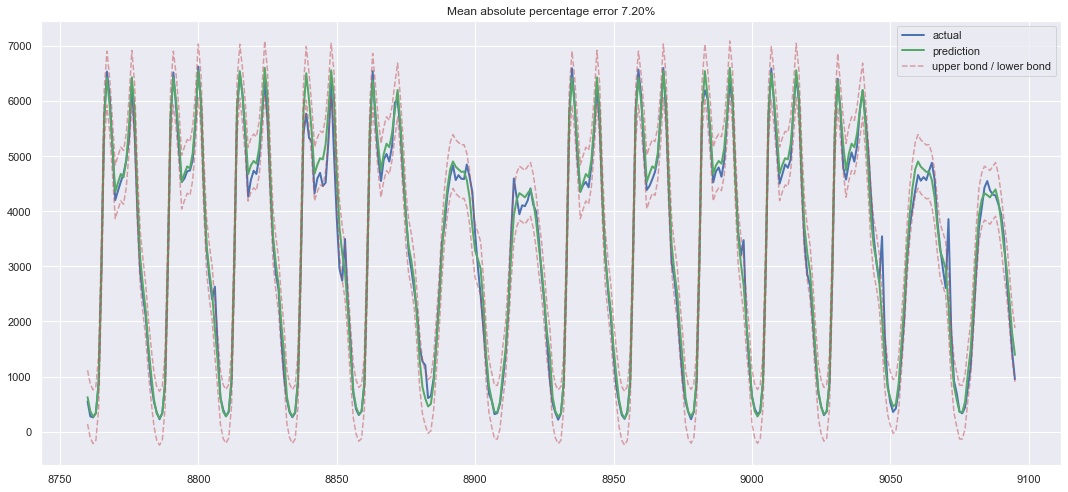

In [54]:
%%time
from catboost import CatBoostRegressor
cat_regr = CatBoostRegressor(logging_level = 'Silent')
cat_regr.fit(X_train, y_train)
plotModelResults(cat_regr, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, plot_intervals=True)

Сработало, ошибка MAPE уменьшилась до 7,2%.

## FB Prophet

Для использования библиотеки Prophet нужно подготовить датасет особым образом.

In [55]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly

df_fbp = pd.DataFrame()
df_fbp['ds'] = pd.to_datetime(df['date_time'])
df_fbp['y'] = df['traffic_volume'].values

In [56]:
df_fbp = df_fbp.loc[df_fbp['ds'] > pd.to_datetime('2017-09-17')].reset_index(drop=True)

In [58]:
fbtrain = df_fbp.loc[df_fbp['ds'] < pd.to_datetime('2018-09-17')].copy()
fbtest = df_fbp.loc[df_fbp['ds'] >= pd.to_datetime('2018-09-17')].copy()

fbpred = fbtest[['ds']].copy()

В библиотеке есть встроенная функция добавления информации о государственных праздниках, что улучшает качество прогнозирования. Сделаем обучение и предсказание.

In [78]:
fbmodel = Prophet()
fbmodel.add_country_holidays(country_name='US')
fbmodel.fit(fbtrain)

forecast = fbmodel.predict(fbpred)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


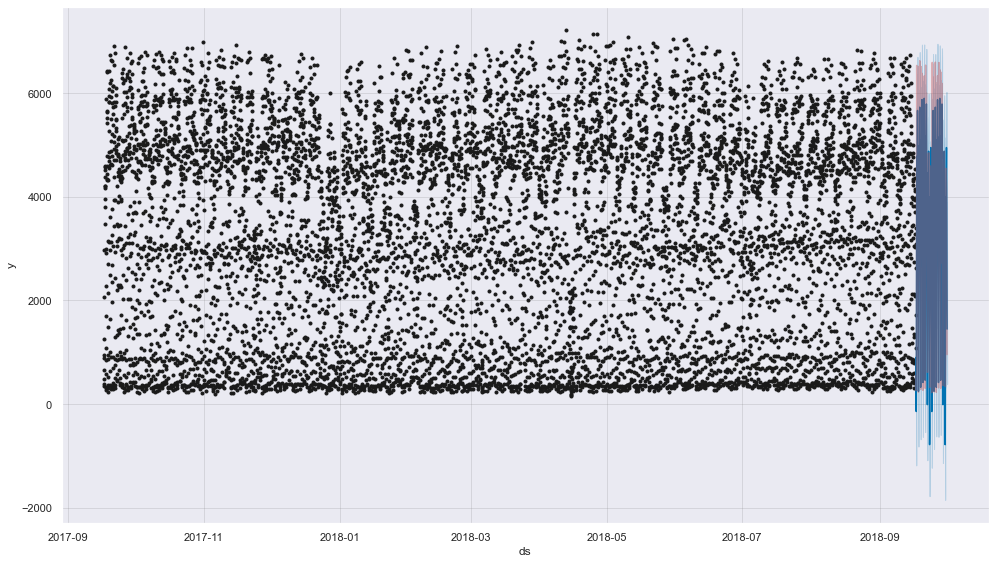

In [79]:
fig2 = fbmodel.plot(forecast, figsize=(14,8))
plt.plot(fbtest['ds'], fbtest['y'], c='r', alpha=0.4)
plt.show()

На построенном графике видно, что модель сильно ошибается, прогнозируя даже отрицательные значения трафика.

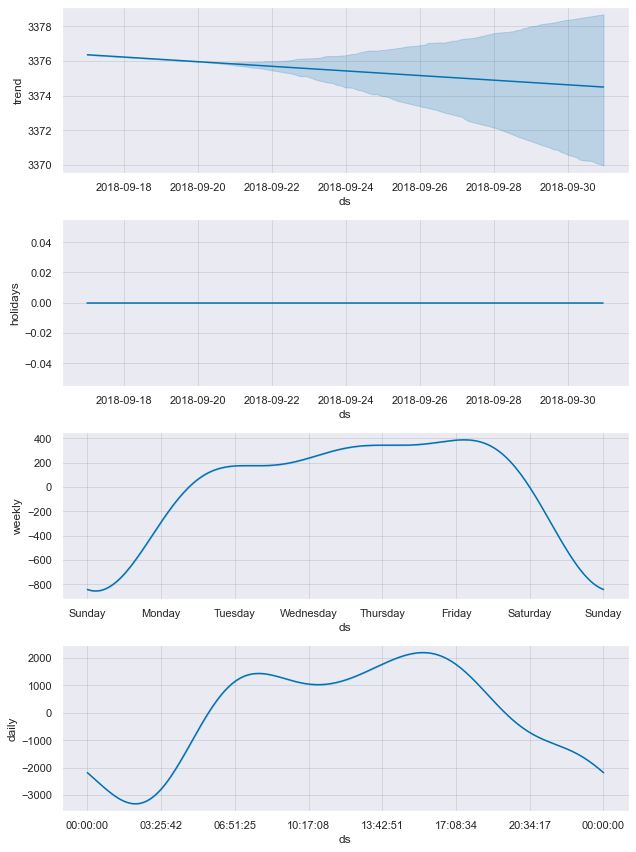

In [80]:
_ = fbmodel.plot_components(forecast)

In [81]:
mean_absolute_percentage_error(forecast['yhat'].values,fbtest['y'].values)

75.78102972425631

Ошибка MAPE сильно зашкаливает.

## GluonTS

Из-за пока невыясненных проблем с установкой модуля в Anaconda расчёты с использованием пакета GluonTS сделал в отдельном ноутбуке на платформе Google Colab. Там ошибка MAPE для модели из коробки составила 12,08%.

## Выводы

Для выбранного датасета протестированы разные подходы к прогнозированию во времени целевой переменной. По метрике качества MAPE лучший результат показал CatBoost.